In [4]:
from dotenv import load_dotenv
from huggingface_hub import login
import os
# Load environment variables from .env
load_dotenv()
token=os.getenv("HUGGINGFACE_TOKEN")
login(token=os.getenv("HUGGINGFACE_TOKEN"))
print("Token loaded?" , token is not None)

Token loaded? True


In [7]:
from datasets import load_dataset

local_dir = "hest_data"
ids_to_query = ["TENX96"]
list_patterns = [f"*{id}[_.]**" for id in ids_to_query]

dataset = load_dataset(
    'MahmoodLab/hest',
    cache_dir=local_dir,
    patterns=list_patterns
)


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

TENX96.tif:  72%|#######1  | 2.83G/3.94G [00:00<?, ?B/s]

Unzipping cell vit segmentation...


100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
import os

for root, dirs, files in os.walk("hest_data"):
    for file in files:
        if "TENX96" in file:
            print(os.path.join(root, file))


hest_data/transcripts/TENX96_transcripts.parquet
hest_data/wsis/TENX96.tif
hest_data/spatial_plots/TENX96_spatial_plots.png
hest_data/xenium_seg/TENX96_xenium_cell_seg.geojson.zip
hest_data/xenium_seg/TENX96_xenium_cell_seg.parquet
hest_data/xenium_seg/TENX96_xenium_nucleus_seg.geojson.zip
hest_data/xenium_seg/TENX96_xenium_nucleus_seg.parquet
hest_data/patches/TENX96.h5
hest_data/datasets--MahmoodLab--hest/.no_exist/cf37675c2006e6dfcdaa084ddeca863d21a8ddbb/wsis/TENX96.tiff
hest_data/pixel_size_vis/TENX96_pixel_size_vis.png
hest_data/patches_vis/TENX96_patch_vis.jpg
hest_data/st/TENX96.h5ad
hest_data/tissue_seg/TENX96_contours.geojson
hest_data/tissue_seg/TENX96_vis.jpg
hest_data/.cache/huggingface/download/transcripts/TENX96_transcripts.parquet.metadata
hest_data/.cache/huggingface/download/transcripts/TENX96_transcripts.parquet.lock
hest_data/.cache/huggingface/download/wsis/TENX96.tif.lock
hest_data/.cache/huggingface/download/wsis/TENX96.tif.metadata
hest_data/.cache/huggingface/do

Xenium coordinate columns: Index(['transcript_id', 'cell_id', 'overlaps_nucleus', 'feature_name',
       'x_location', 'y_location', 'z_location', 'qv', 'x_location_pxl',
       'y_location_pxl', 'dapi_x', 'dapi_y', 'he_x', 'he_y'],
      dtype='object')


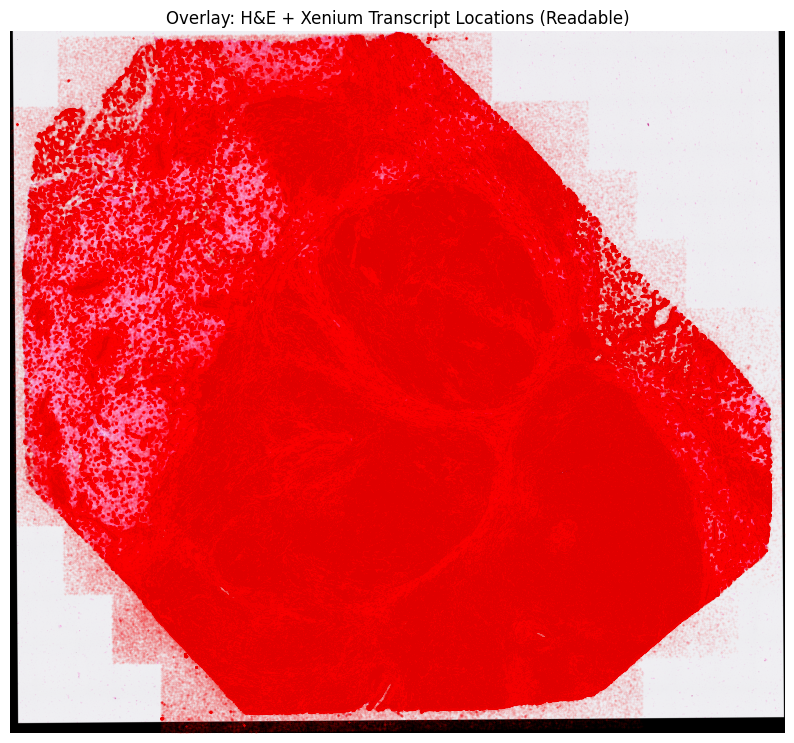

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Prevent PIL from throwing DecompressionBombError for huge images
Image.MAX_IMAGE_PIXELS = None

# === Load Paths ===
he_image_path = "hest_data/wsis/TENX96.tif"
transcript_path = "hest_data/transcripts/TENX96_transcripts.parquet"

# === Load Image and Transcript ===
he_image = Image.open(he_image_path)
df = pd.read_parquet(transcript_path)

# Preview coordinates
print("Xenium coordinate columns:", df.columns)
# Downsample image to make things smoother
he_image = he_image.resize((he_image.width // 8, he_image.height // 8))
df["he_x_resized"] = df["he_x"] / 8
df["he_y_resized"] = df["he_y"] / 8

# Plot with smaller, transparent dots
plt.figure(figsize=(10, 10))
plt.imshow(he_image, alpha=1.0)
plt.scatter(
    df["he_x_resized"],
    df["he_y_resized"],
    s=0.2,              # much smaller size
    c="red",
    alpha=0.05          # very transparent
)
plt.title("Overlay: H&E + Xenium Transcript Locations (Readable)")
plt.axis("off")
plt.show()



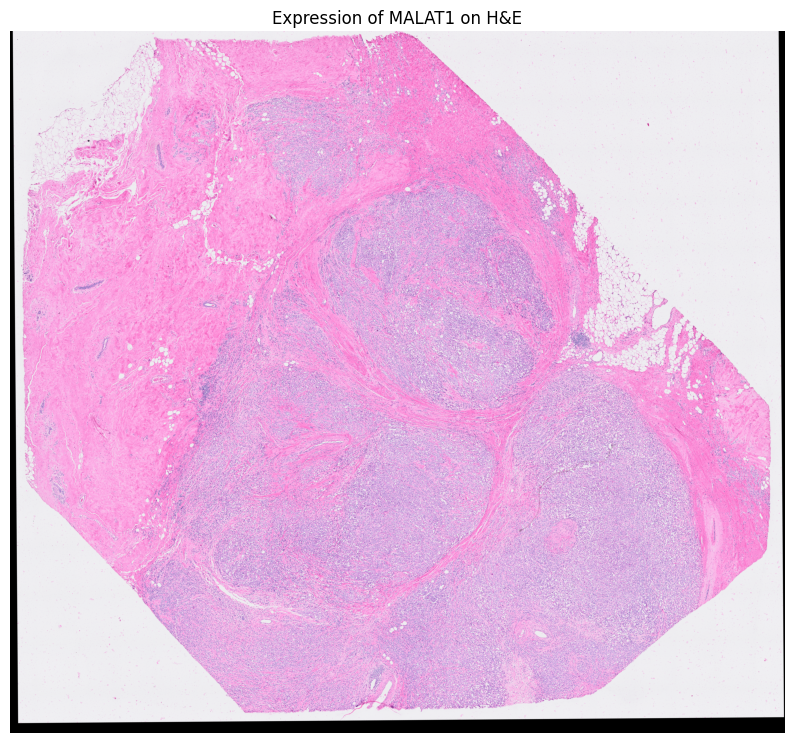

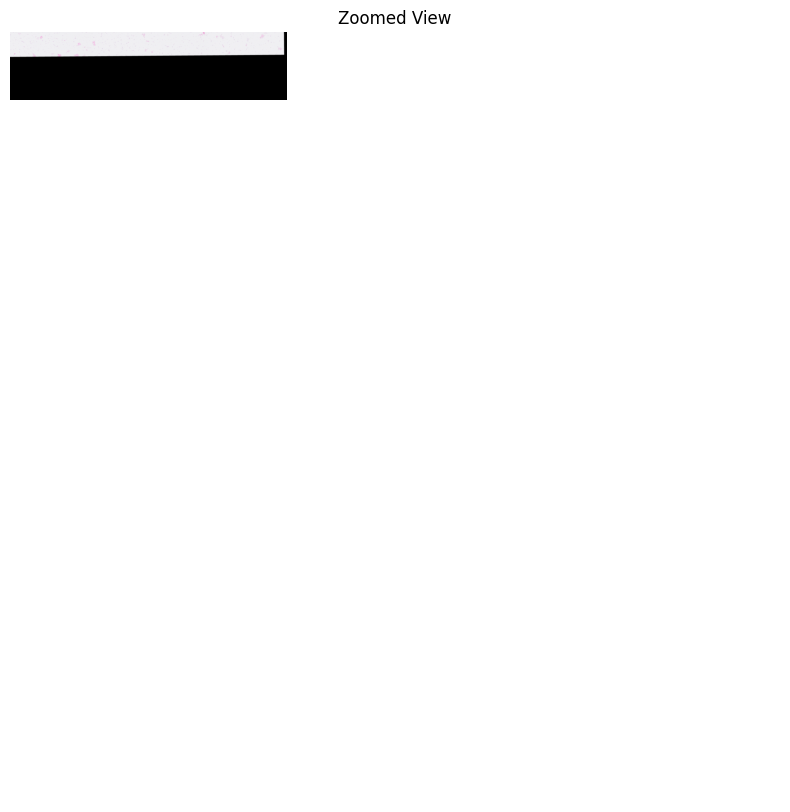

DataSourceError: '/vsizip/hest_data/xenium_seg/TENX96_xenium_nucleus_seg.geojson.zip' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

In [5]:
# Visualize a Specific Gene
gene = "MALAT1"  # Replace with a gene name you know exists
df_gene = df[df["feature_name"] == gene]

plt.figure(figsize=(10, 10))
plt.imshow(he_image, alpha=1.0)
plt.scatter(
    df_gene["he_x_resized"],
    df_gene["he_y_resized"],
    s=5, c="cyan", alpha=0.5
)
plt.title(f"Expression of {gene} on H&E")
plt.axis("off")
plt.show()
# Zoomed in view

plt.figure(figsize=(10, 10))
plt.imshow(he_image, alpha=1.0)
plt.scatter(df["he_x_resized"], df["he_y_resized"], s=0.2, c="red", alpha=0.05)
plt.xlim(5000, 7000)  # Customize these values
plt.ylim(7000, 5000)  # Note: y is flipped!
plt.title("Zoomed View")
plt.axis("off")
plt.show()
# Overlay Nucleus Segmentation
import geopandas as gpd
nucleus_gdf = gpd.read_file("hest_data/xenium_seg/TENX96_xenium_nucleus_seg.geojson.zip")


# Resize if needed
nucleus_gdf["geometry"] = nucleus_gdf["geometry"].scale(xfact=1/8, yfact=1/8, origin=(0, 0))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(he_image, alpha=1.0)
nucleus_gdf.plot(ax=ax, edgecolor="lime", linewidth=0.2, alpha=0.3)
plt.axis("off")
plt.title("H&E with Xenium Nucleus Segmentation")
plt.show()
